<h1>Predicting Adverse Drug Reactions With Machine Learning</h1>

In [1]:
# Misc
from sklearn.model_selection import train_test_split
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# Functions
from mlprocess import *
from params_by_label import *

# Fixing the seed
seed = 6
np.random.seed(seed)

""" Careful when importing saved dataframes with label names as indexes -> index = True """

' Careful when importing saved dataframes with label names as indexes -> index = True '

<h2>1. Introduction</h2>
<p>The objective of this work is to develop machine learning (ML) methods that can accurately predict adverse drug reactions (ADRs) using databases like SIDER and OFFSIDES.</p> 
<h2>2. Methods</h2>
<h3>2.1 Methods</h3>
<p>One of the most important factors when using ML methods are the datasets used to train, validate and test the model. In this work, 3 different ones will be used at different stages, shown in table 1.</p> 

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-0lax"><span style="font-weight:bold">Dataset</span></th>
    <th class="tg-0lax"><span style="font-weight:bold">Description</span></th>
  </tr>
  <tr>
    <td class="tg-0lax">SIDER 4</td>
    <td class="tg-0lax">1427 Approved drugs with ADRs text-mined from drug package inserts grouped into 27 system organ classes following <br>MedDRA classification</td>
  </tr>
  <tr>
    <td class="tg-0lax">OFFSIDES</td>
    <td class="tg-0lax">Database of off-label side effects</td>
  </tr>
</table>

<h3>2.2 Features</h3>
<p>Features are the set of attributes associated with the example that try to represent the dataset.</p> 
<p>SMILES strings are commonly used to represent molecules, as is used in SIDER, and they will be the basis of this work. But, even though they are a unique representation of molecules, they are not enough to use as a feature in ML. Because of this, they will be used as a way to generate other features like fingerprints and molecular descriptors using tools like RDKit in Python.</p> 

<h3>2.3 Machine Learning Methods</h3>
<p>SMILES strings are commonly used to represent molecules, as is used in SIDER, and they were the basis of this work. But, even though they are a unique representation of molecules, they are not enough to use as a feature in ML. Because of this, they were also used as a way to generate other features like fingerprints and molecular descriptors using tools like RDKit in Python.</p>

The general workflow for the datasets when in SIDER format is displayed in the following figure:

<img src="jupyter_images/sider.png" alt="Drawing" style="width: 600px;"/>

The SIDER dataset consists of a first column with the molecules' SMILES representation and other twenty-seven columns with the different SOCs. Three of these SOCs were not used since they had no real connection with the molecule and, as such, the development of ML models to predict these labels was not useful, these were 'Product Issues', 'Investigations', and 'Social circumstances'. 

With the SMILES representation, it was possible to create multiple different features using RDKit, mainly fingerprint and other descriptors, for example, molecular weight, number of radical electrons, and number of valence electrons. We used these to add relevant information that complements the fingerprint. 

In total, 27 descriptors were calculated for each molecule, not every descriptor was useful and, as such, some selection was required. But, since we had 24 different classification tasks, each with an independent model, and different descriptors had a different importance for each of them, this selection was made independently for each task, what resulted in 24 different DataFrames consisting in the fingerprint representation plus the 3 (after testing different values) descriptors selected to each task. Example in the following table:

In [2]:
# Creating base df_molecules, df_y with the results vectors, and df_mols_descr with the descriptors
print("Creating Dataframes")
y_all, df_molecules = create_original_df(write_s=False)
df_molecules.drop("smiles", axis=1, inplace=True)
todrop = ["Product issues", "Investigations", "Social circumstances"]
y_all.drop(todrop, axis=1, inplace=True)  # No real connection with the molecule, multiple problems
out_names = y_all.columns.tolist()  # Get class labels

# Separating in a DF_mols_train and an Df_mols_test, in order to avoid data snooping and fitting the model to the test
df_mols_train, df_mols_test, y_train, y_test = train_test_split(df_molecules, y_all, test_size=0.2, random_state=seed)

# Fingerprint length
#all_df_results_svc = test_fingerprint_size(df_mols_train, y_train, SVC(gamma="scale", random_state=seed), makeplots=True, write=False)
# Best result with ECFP-4 at 1125 - This will be used to all results


Creating Dataframes


In [3]:

# Create X datasets with fingerprint length
X_all, _, _, _ = createfingerprints(df_molecules, length=1125)
X_train_fp, _, _, _ = createfingerprints(df_mols_train, length=1125)
X_test_fp, _, _, _ = createfingerprints(df_mols_test, length=1125)

# Selects and create descriptors dataset
df_desc = createdescriptors(df_molecules)  # Create all descriptors

# Splits in train and test
df_desc_base_train, df_desc_base_test = train_test_split(df_desc, test_size=0.2, random_state=seed)

# Creates a dictionary with key = class label and value = dataframe with fingerprint + best K descriptors for that label
X_train_dic, X_test_dic, selected_cols = create_dataframes_dic(df_desc_base_train, df_desc_base_test, X_train_fp,
                                                               X_test_fp, y_train, out_names, score_func=f_classif, k=3)
# Creates a y dictionary for all labels
y_train_dic = {name: y_train[name] for name in out_names}
modelnamesvc = {name: "SVC" for name in out_names}
modelnamerf = {name: "RF" for name in out_names}
modelnamexgb = {name: "XGB" for name in out_names}
modelnamevot = {name: "VotingClassifier" for name in out_names}

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 112.05it/s]


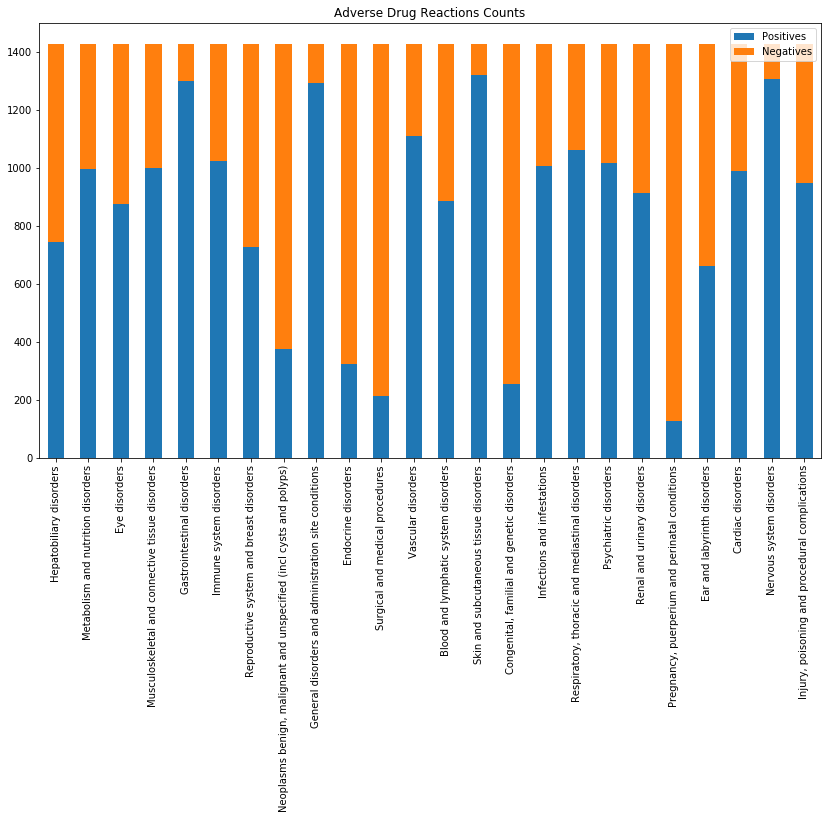

In [4]:
d = {"Positives": y_all.sum(axis=0), "Negatives": 1427 - y_all.sum(axis=0)}
countsm = pd.DataFrame(data=d)
df_perc = countsm / 1427
countsm.plot(kind='bar', figsize=(14, 8), title="Adverse Drug Reactions Counts", ylim=(0, 1500), stacked=True)

In [5]:
print("SVC")
print("Base SVC without balancing:")
base_svc_report = cv_multi_report(X_train_dic, y_train, out_names, SVC(gamma="auto", random_state=seed), n_splits=5,
                                  n_jobs=-2, verbose=False)

SVC
Base SVC without balancing:


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]


Scores for Hepatobiliary disorders

Individual metrics
F1 Micro Score: Mean: 0.643 (Std: 0.037)
F1 Macro Score: Mean: 0.622 (Std: 0.042)
F1 Binary Score: Mean: 0.712 (Std: 0.027)
ROC-AUC score: Mean: 0.676 (Std: 0.050)
Recall score: Mean: 0.851 (Std: 0.023)
Precision score: Mean: 0.612 (Std: 0.028)
Average Precision score: Mean: 0.660 (Std: 0.049)



  4%|███▍                                                                               | 1/24 [00:05<02:13,  5.81s/it]


Scores for Metabolism and nutrition disorders

Individual metrics
F1 Micro Score: Mean: 0.692 (Std: 0.001)
F1 Macro Score: Mean: 0.409 (Std: 0.000)
F1 Binary Score: Mean: 0.818 (Std: 0.001)
ROC-AUC score: Mean: 0.565 (Std: 0.044)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.692 (Std: 0.001)
Average Precision score: Mean: 0.732 (Std: 0.031)



  8%|██████▉                                                                            | 2/24 [00:09<01:56,  5.30s/it]


Scores for Eye disorders

Individual metrics
F1 Micro Score: Mean: 0.624 (Std: 0.011)
F1 Macro Score: Mean: 0.430 (Std: 0.017)
F1 Binary Score: Mean: 0.763 (Std: 0.007)
ROC-AUC score: Mean: 0.597 (Std: 0.039)
Recall score: Mean: 0.984 (Std: 0.012)
Precision score: Mean: 0.622 (Std: 0.006)
Average Precision score: Mean: 0.687 (Std: 0.023)



 12%|██████████▍                                                                        | 3/24 [00:14<01:44,  4.97s/it]


Scores for Musculoskeletal and connective tissue disorders

Individual metrics
F1 Micro Score: Mean: 0.687 (Std: 0.001)
F1 Macro Score: Mean: 0.407 (Std: 0.000)
F1 Binary Score: Mean: 0.815 (Std: 0.001)
ROC-AUC score: Mean: 0.648 (Std: 0.040)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.687 (Std: 0.001)
Average Precision score: Mean: 0.802 (Std: 0.025)



 17%|█████████████▊                                                                     | 4/24 [00:17<01:30,  4.53s/it]


Scores for Gastrointestinal disorders

Individual metrics
F1 Micro Score: Mean: 0.907 (Std: 0.002)
F1 Macro Score: Mean: 0.476 (Std: 0.000)
F1 Binary Score: Mean: 0.951 (Std: 0.001)
ROC-AUC score: Mean: 0.672 (Std: 0.031)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.907 (Std: 0.002)
Average Precision score: Mean: 0.945 (Std: 0.008)



 21%|█████████████████▎                                                                 | 5/24 [00:19<01:08,  3.61s/it]


Scores for Immune system disorders

Individual metrics
F1 Micro Score: Mean: 0.726 (Std: 0.001)
F1 Macro Score: Mean: 0.421 (Std: 0.000)
F1 Binary Score: Mean: 0.841 (Std: 0.001)
ROC-AUC score: Mean: 0.559 (Std: 0.018)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.726 (Std: 0.001)
Average Precision score: Mean: 0.777 (Std: 0.016)



 25%|████████████████████▊                                                              | 6/24 [00:22<01:02,  3.47s/it]


Scores for Reproductive system and breast disorders

Individual metrics
F1 Micro Score: Mean: 0.608 (Std: 0.021)
F1 Macro Score: Mean: 0.608 (Std: 0.021)
F1 Binary Score: Mean: 0.609 (Std: 0.028)
ROC-AUC score: Mean: 0.652 (Std: 0.029)
Recall score: Mean: 0.611 (Std: 0.045)
Precision score: Mean: 0.608 (Std: 0.020)
Average Precision score: Mean: 0.625 (Std: 0.032)



 29%|████████████████████████▏                                                          | 7/24 [00:26<01:02,  3.69s/it]


Scores for Neoplasms benign, malignant and unspecified (incl cysts and polyps)

Individual metrics
F1 Micro Score: Mean: 0.745 (Std: 0.001)
F1 Macro Score: Mean: 0.427 (Std: 0.000)
F1 Binary Score: Mean: 0.000 (Std: 0.000)
ROC-AUC score: Mean: 0.679 (Std: 0.018)
Recall score: Mean: 0.000 (Std: 0.000)
Precision score: Mean: 0.000 (Std: 0.000)
Average Precision score: Mean: 0.470 (Std: 0.043)



 33%|███████████████████████████▋                                                       | 8/24 [00:29<00:55,  3.45s/it]


Scores for General disorders and administration site conditions

Individual metrics
F1 Micro Score: Mean: 0.910 (Std: 0.002)
F1 Macro Score: Mean: 0.476 (Std: 0.000)
F1 Binary Score: Mean: 0.953 (Std: 0.001)
ROC-AUC score: Mean: 0.603 (Std: 0.037)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.910 (Std: 0.002)
Average Precision score: Mean: 0.938 (Std: 0.012)



 38%|███████████████████████████████▏                                                   | 9/24 [00:30<00:43,  2.91s/it]


Scores for Endocrine disorders

Individual metrics
F1 Micro Score: Mean: 0.786 (Std: 0.001)
F1 Macro Score: Mean: 0.440 (Std: 0.000)
F1 Binary Score: Mean: 0.000 (Std: 0.000)
ROC-AUC score: Mean: 0.631 (Std: 0.037)
Recall score: Mean: 0.000 (Std: 0.000)
Precision score: Mean: 0.000 (Std: 0.000)
Average Precision score: Mean: 0.391 (Std: 0.072)



 42%|██████████████████████████████████▏                                               | 10/24 [00:33<00:40,  2.89s/it]


Scores for Surgical and medical procedures

Individual metrics
F1 Micro Score: Mean: 0.855 (Std: 0.001)
F1 Macro Score: Mean: 0.461 (Std: 0.000)
F1 Binary Score: Mean: 0.000 (Std: 0.000)
ROC-AUC score: Mean: 0.527 (Std: 0.061)
Recall score: Mean: 0.000 (Std: 0.000)
Precision score: Mean: 0.000 (Std: 0.000)
Average Precision score: Mean: 0.187 (Std: 0.049)



 46%|█████████████████████████████████████▌                                            | 11/24 [00:37<00:39,  3.01s/it]


Scores for Vascular disorders

Individual metrics
F1 Micro Score: Mean: 0.769 (Std: 0.001)
F1 Macro Score: Mean: 0.435 (Std: 0.000)
F1 Binary Score: Mean: 0.869 (Std: 0.001)
ROC-AUC score: Mean: 0.577 (Std: 0.050)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.769 (Std: 0.001)
Average Precision score: Mean: 0.817 (Std: 0.025)



 50%|█████████████████████████████████████████                                         | 12/24 [00:40<00:35,  2.99s/it]


Scores for Blood and lymphatic system disorders

Individual metrics
F1 Micro Score: Mean: 0.633 (Std: 0.014)
F1 Macro Score: Mean: 0.458 (Std: 0.023)
F1 Binary Score: Mean: 0.766 (Std: 0.009)
ROC-AUC score: Mean: 0.661 (Std: 0.030)
Recall score: Mean: 0.981 (Std: 0.015)
Precision score: Mean: 0.628 (Std: 0.007)
Average Precision score: Mean: 0.742 (Std: 0.028)



 54%|████████████████████████████████████████████▍                                     | 13/24 [00:44<00:36,  3.29s/it]


Scores for Skin and subcutaneous tissue disorders

Individual metrics
F1 Micro Score: Mean: 0.927 (Std: 0.002)
F1 Macro Score: Mean: 0.481 (Std: 0.000)
F1 Binary Score: Mean: 0.962 (Std: 0.001)
ROC-AUC score: Mean: 0.593 (Std: 0.046)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.927 (Std: 0.002)
Average Precision score: Mean: 0.949 (Std: 0.009)



 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:45<00:27,  2.71s/it]


Scores for Congenital, familial and genetic disorders

Individual metrics
F1 Micro Score: Mean: 0.824 (Std: 0.001)
F1 Macro Score: Mean: 0.452 (Std: 0.000)
F1 Binary Score: Mean: 0.000 (Std: 0.000)
ROC-AUC score: Mean: 0.585 (Std: 0.047)
Recall score: Mean: 0.000 (Std: 0.000)
Precision score: Mean: 0.000 (Std: 0.000)
Average Precision score: Mean: 0.245 (Std: 0.020)



 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:47<00:23,  2.63s/it]


Scores for Infections and infestations

Individual metrics
F1 Micro Score: Mean: 0.710 (Std: 0.001)
F1 Macro Score: Mean: 0.415 (Std: 0.000)
F1 Binary Score: Mean: 0.830 (Std: 0.001)
ROC-AUC score: Mean: 0.655 (Std: 0.032)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.710 (Std: 0.001)
Average Precision score: Mean: 0.815 (Std: 0.026)



 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:51<00:22,  2.84s/it]


Scores for Respiratory, thoracic and mediastinal disorders

Individual metrics
F1 Micro Score: Mean: 0.748 (Std: 0.001)
F1 Macro Score: Mean: 0.428 (Std: 0.000)
F1 Binary Score: Mean: 0.856 (Std: 0.001)
ROC-AUC score: Mean: 0.558 (Std: 0.038)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.748 (Std: 0.001)
Average Precision score: Mean: 0.793 (Std: 0.016)



 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:54<00:20,  2.94s/it]


Scores for Psychiatric disorders

Individual metrics
F1 Micro Score: Mean: 0.699 (Std: 0.001)
F1 Macro Score: Mean: 0.412 (Std: 0.000)
F1 Binary Score: Mean: 0.823 (Std: 0.001)
ROC-AUC score: Mean: 0.618 (Std: 0.027)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.699 (Std: 0.001)
Average Precision score: Mean: 0.773 (Std: 0.027)



 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:57<00:18,  3.11s/it]


Scores for Renal and urinary disorders

Individual metrics
F1 Micro Score: Mean: 0.641 (Std: 0.001)
F1 Macro Score: Mean: 0.390 (Std: 0.000)
F1 Binary Score: Mean: 0.781 (Std: 0.000)
ROC-AUC score: Mean: 0.645 (Std: 0.046)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.641 (Std: 0.001)
Average Precision score: Mean: 0.756 (Std: 0.037)



 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [01:02<00:17,  3.57s/it]


Scores for Pregnancy, puerperium and perinatal conditions

Individual metrics
F1 Micro Score: Mean: 0.915 (Std: 0.002)
F1 Macro Score: Mean: 0.478 (Std: 0.001)
F1 Binary Score: Mean: 0.000 (Std: 0.000)
ROC-AUC score: Mean: 0.514 (Std: 0.093)
Recall score: Mean: 0.000 (Std: 0.000)
Precision score: Mean: 0.000 (Std: 0.000)
Average Precision score: Mean: 0.129 (Std: 0.027)



 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [01:04<00:11,  2.96s/it]


Scores for Ear and labyrinth disorders

Individual metrics
F1 Micro Score: Mean: 0.552 (Std: 0.001)
F1 Macro Score: Mean: 0.356 (Std: 0.000)
F1 Binary Score: Mean: 0.000 (Std: 0.000)
ROC-AUC score: Mean: 0.620 (Std: 0.024)
Recall score: Mean: 0.000 (Std: 0.000)
Precision score: Mean: 0.000 (Std: 0.000)
Average Precision score: Mean: 0.577 (Std: 0.011)



 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [01:08<00:10,  3.57s/it]


Scores for Cardiac disorders

Individual metrics
F1 Micro Score: Mean: 0.693 (Std: 0.001)
F1 Macro Score: Mean: 0.409 (Std: 0.000)
F1 Binary Score: Mean: 0.819 (Std: 0.000)
ROC-AUC score: Mean: 0.641 (Std: 0.022)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.693 (Std: 0.001)
Average Precision score: Mean: 0.795 (Std: 0.017)



 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [01:12<00:07,  3.59s/it]


Scores for Nervous system disorders

Individual metrics
F1 Micro Score: Mean: 0.919 (Std: 0.002)
F1 Macro Score: Mean: 0.479 (Std: 0.000)
F1 Binary Score: Mean: 0.958 (Std: 0.001)
ROC-AUC score: Mean: 0.633 (Std: 0.053)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.919 (Std: 0.002)
Average Precision score: Mean: 0.954 (Std: 0.010)



 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [01:13<00:02,  2.91s/it]


Scores for Injury, poisoning and procedural complications

Individual metrics
F1 Micro Score: Mean: 0.665 (Std: 0.001)
F1 Macro Score: Mean: 0.399 (Std: 0.000)
F1 Binary Score: Mean: 0.799 (Std: 0.001)
ROC-AUC score: Mean: 0.568 (Std: 0.045)
Recall score: Mean: 1.000 (Std: 0.000)
Precision score: Mean: 0.665 (Std: 0.001)
Average Precision score: Mean: 0.730 (Std: 0.024)



100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:17<00:00,  3.11s/it]
